In [6]:
import torch

print('현재 import 된 torch 의 버전 : ', torch.__version__)
print('너 CUDA 사용 할 수 있니 ?' , torch.cuda.is_available())

현재 import 된 torch 의 버전 :  2.1.0
너 CUDA 사용 할 수 있니 ? True


In [7]:
import warnings

warnings.filterwarnings(action = 'ignore')

In [29]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt 

In [10]:
alexnet = torchvision.models.alexnet(pretrained=False)

In [11]:
alexnet.classifier[6] = nn.Linear(in_features = 4096, out_features = 10) # 데이터셋에 맞춰 output layer 변경

In [20]:
# Transformations for the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # Resize to 224x224
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(224, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the size of the subset (1/10 of the full dataset)
subset_size = len(full_trainset) // 100

# Use SubsetRandomSampler to get a subset of the data
subset_indices = list(range(subset_size))
subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(subset_indices)

trainloader = torch.utils.data.DataLoader(
    full_trainset, batch_size=256, sampler=subset_sampler,num_workers=0)

Files already downloaded and verified


In [28]:
device_name = ['cuda:0','cpu']

device_time = {'cpu' : [], 'cuda:0' : []}
device_loss=  {'cpu' : [], 'cuda:0' : []}

for i in range(2):
    device = device_name[i]
    model = alexnet.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    start_time = time.time()
    print('==' * 20)
    print(f'{device} 학습 시작')
    for epoch in range(10):

        running_loss = 0.0 
        
        for i , data in enumerate(trainloader, 0):
            
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        end_time = time.time()
        cumalative_time = end_time - start_time
        device_time[device]. append(cumalative_time)
        device_loss[device].append(running_loss)
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader)} Training Time : {cumalative_time}")

cuda:0 학습 시작
Epoch 1, Loss: 2.3009642362594604 Training Time : 1.2184703350067139
Epoch 2, Loss: 2.3011921644210815 Training Time : 2.3907482624053955
Epoch 3, Loss: 2.3011661767959595 Training Time : 3.5886964797973633
Epoch 4, Loss: 2.301073670387268 Training Time : 4.787355184555054
Epoch 5, Loss: 2.301165223121643 Training Time : 5.945833206176758
Epoch 6, Loss: 2.300950050354004 Training Time : 7.133103370666504
Epoch 7, Loss: 2.300744891166687 Training Time : 8.347835063934326
Epoch 8, Loss: 2.3009177446365356 Training Time : 9.505252599716187
Epoch 9, Loss: 2.3009179830551147 Training Time : 10.677955150604248
Epoch 10, Loss: 2.300806164741516 Training Time : 11.837180614471436
cpu 학습 시작
Epoch 1, Loss: 2.3007757663726807 Training Time : 12.329620599746704
Epoch 2, Loss: 2.300844192504883 Training Time : 24.864909410476685
Epoch 3, Loss: 2.300822615623474 Training Time : 36.994953632354736
Epoch 4, Loss: 2.3006317615509033 Training Time : 49.31385636329651
Epoch 5, Loss: 2.300786

Text(0.5, 1.0, 'Training Time : CPU vs CUDA')

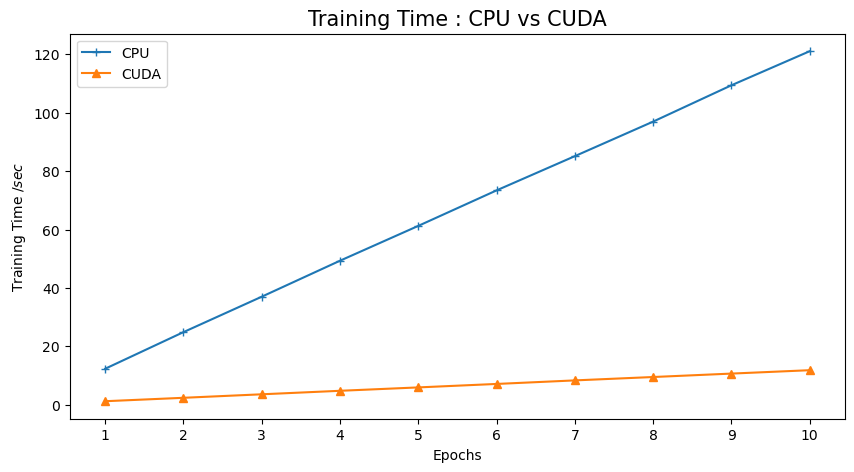

In [47]:
num_epochs = list(range(1,10 + 1))

fig,ax = plt.subplots(figsize = (10,5))

ax.plot(num_epochs,device_time['cpu'], label = 'CPU', marker = '+')
ax.plot(num_epochs,device_time['cuda:0'], label = 'CUDA', marker = '^')
ax.set_xticks(num_epochs)
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Time $/sec$')
ax.legend(loc = 'best')

ax.set_title('Training Time : CPU vs CUDA', fontsize = 15)